In [31]:
# !pip install keras-unet
from keras_unet.utils import get_patches
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

from keras.models import load_model

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Loading data

In [6]:
DATA_PATH = '../data/processed'
MODEL_PATH = '../models'

def load_data(year, img_h=1400, img_w=1400):

    X = []
    y = []

    data_dir = os.path.join(DATA_PATH, str(year))
    frames_dir = os.path.join(data_dir, 'frames')
    masks_dir = os.path.join(data_dir, 'masks')

    for file in sorted(os.listdir(frames_dir)):
        if file.startswith('R'):
            filename = file.split('.')[0]

            frame = np.load(os.path.join(frames_dir, filename + '.npy'))
            mask = np.load(os.path.join(masks_dir, filename + '_labels.npy'))
            X.append(frame[:img_h, :img_w, :])
            y.append(mask[:img_h, :img_w])

    X = np.array(X)
    y = np.array(y)

    return X, y

## Get smaller patches/crops from bigger image

In [27]:
def get_img_patches(X, y, crop_size=512):

    y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
    
    X_crops = []
    y_crops = []

    CROP_SIZE = 512

    for i, x in enumerate(X):
        x_sample = get_patches(
            img_arr=x, 
            size=crop_size, 
            stride=crop_size) 

        y_sample = get_patches(
          img_arr=y[i],
          size=crop_size, 
          stride=crop_size)

        X_crops.append(x_sample)
        y_crops.append(y_sample)

    X_crops = np.array(X_crops)
    X_crops = X_crops.reshape(X_crops.shape[0] * X_crops.shape[1], X_crops.shape[2], X_crops.shape[3], X_crops.shape[4])
    
    y_crops = np.array(y_crops)
    y_crops = np.array(y_crops).reshape(y_crops.shape[0] * y_crops.shape[1], y_crops.shape[2], y_crops.shape[3], 1)
  
    return X_crops, y_crops

In [8]:
def standardize(X):

    # flatten X to 2D array
    X_reshaped = X.reshape(-1, X.shape[-1])

    # standardize on columns
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)

    # reshape X to original shape
    X_final = X_scaled.reshape(X.shape)

    return X_final

## Metrics

In [39]:
def intersection_over_union(confusion_matrix):
    """ Intersection-over-union metric for image segmentation """
    
    tn, fp, fn, tp = confusion_matrix.ravel()
    iou = tp / (tp + fn + fp)
    return iou

def print_metrics(y_true, y_pred):
    """ Print classification metrics  """
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    print('Accuracy: %.2f' % accuracy_score(y_true_flat, y_pred_flat))
    print('Intersection-over-Union: %.2f' % intersection_over_union(cm))
    print('Confusion Matrix: \n', cm)
    print('Classification report:\n', classification_report(y_true_flat, y_pred_flat))

## Visualization

In [56]:
def plot_image(image, factor=1):
    """ Plot RGB spectral bands """    
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)
        
def plot_labels(labels):
    """ Plot corn labels """
    
    plt.imshow(labels, cmap='viridis')
    
def plot_labels_overlay(image, labels):
    """ Plot satellite image with corn labels """
    
    y_ = labels.astype('float')
    y_[y_==0] = np.nan

    plot_image(image, 7)
    plt.imshow(y_, cmap='viridis_r')
    
def plot_all(image, y_true, y_pred, size=500, figsize=(20,10)):
    
    f = plt.figure(figsize=figsize)

    plt.subplot(141)
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])
    plot_image(image[:size,:size,[3,2,1]], 7)

    plt.subplot(142)
    plt.title('Ground Truth')
    plt.xticks([])
    plt.yticks([])
    plot_labels(y_true[:size,:size])

    if y_pred.size:
        plt.subplot(143)
        plt.title('Prediction')
        plt.xticks([])
        plt.yticks([])
        plot_labels(y_pred[:size,:size])

        plt.subplot(144)
        plt.title('Overlay')
        plt.xticks([])
        plt.yticks([])
        plot_labels_overlay(image[:size,:size,[3,2,1]], y_pred[:size,:size])

## Training on 2017 Data

In [19]:
X, y = load_data(year=2017)
X.shape

(30, 1400, 1400, 13)

In [29]:
X_scaled = standardize(X)
X_crops, y_crops = get_img_patches(X_scaled, y)
X_crops.shape

(120, 512, 512, 13)

## Train/val split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_reshaped, test_size=0.2, shuffle=False)

print("x_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", X_val.shape)
print("y_val: ", y_val.shape)

x_train:  (96, 512, 512, 13)
y_train:  (96, 512, 512, 1)
x_val:  (24, 512, 512, 13)
y_val:  (24, 512, 512, 1)



## Prepare train generator with data augmentation

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True,
    ))

## Initialize network

In [0]:
from keras_unet.models import custom_unet

input_shape = X_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    num_classes=1,
    dropout=0.3,
    num_layers=4
)

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 13) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 3776        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 512, 512, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 512, 512, 32) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

## Compile + train

In [0]:
from keras.callbacks import ModelCheckpoint

model_filename = os.path.join(MODEL_PATH,'unet_model_v1.h5')
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [0]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    loss='binary_crossentropy',
    metrics=[iou]
)

## Training model

In [0]:
history = model.fit_generator(
    train_gen,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[callback_checkpoint]
)

## Validation Results

In [0]:
y_pred = model.predict(X_val)
y_pred_binary = np.round_(y_pred, 0)

In [54]:
print_metrics(y_val, y_pred_binary)

Accuracy: 0.95
IoU: 0.80
Confusion Matrix: 
 [[4610931  225429]
 [ 117315 1337781]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96   4728246
         1.0       0.92      0.86      0.89   1563210

    accuracy                           0.95   6291456
   macro avg       0.94      0.92      0.93   6291456
weighted avg       0.94      0.95      0.94   6291456



## Testing on 2018 data

### Loading and process data

In [35]:
X, y = load_data(year=2018)
X_scaled = standardize(X)
X_crops, y_crops = get_img_patches(X_scaled, y)

### Loading trained U-net model

In [36]:
dependencies = { 'iou': iou }
model = load_model(os.path.join(MODEL_PATH, 'segm_model_v3.h5'), custom_objects=dependencies)

### Making predictions on 2018 data

In [37]:
y_pred = model.predict(X_crops)

# Rounding probabilities to 0/1
y_pred_binary = np.round_(y_pred, 0)

In [40]:
print_metrics(y_crops, y_pred_binary)

Accuracy: 0.94
Intersection-over-Union: 0.82
Confusion Matrix: 
 [[15977286   888105]
 [  617636  6634221]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95  16865391
           1       0.88      0.91      0.90   7251857

    accuracy                           0.94  24117248
   macro avg       0.92      0.93      0.93  24117248
weighted avg       0.94      0.94      0.94  24117248



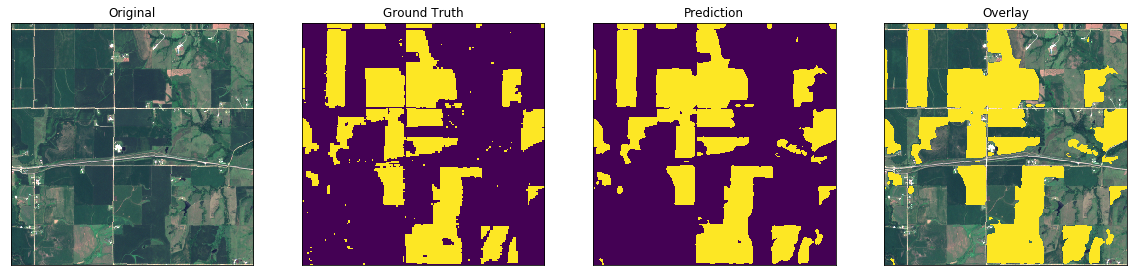

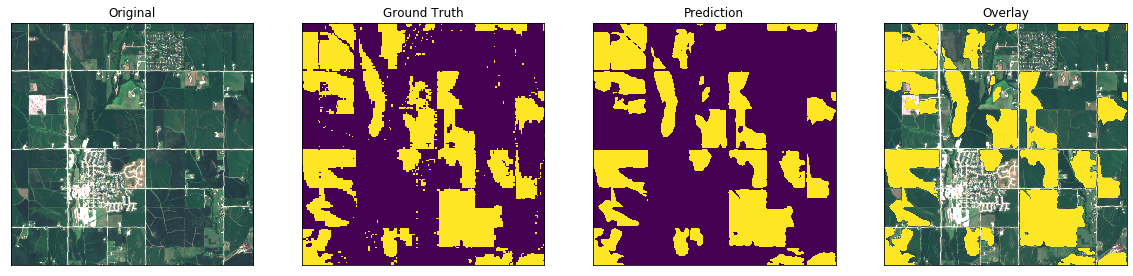

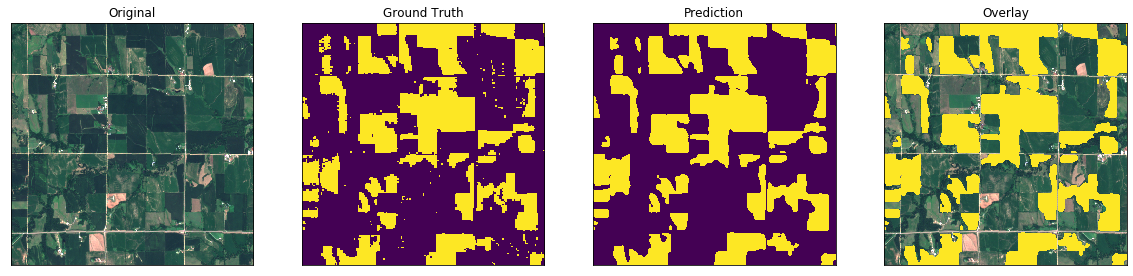

In [70]:
for i in range(3):
    idx = np.random.randint(0,len(y_crops))
    plot_all(X_crops[idx], y_crops[idx,:,:,0], y_pred_binary[idx,:,:,0])